# Consistency between the dataset underpinning the Copernicus Interactive Climate Atlas and its origins: Multiple origin datasets

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**

Production date: DD-MM-YYYY

Dataset version: 2.0.

Produced by: C3S2_521 contract.

## 🌍 Use case: Retrieving climate indicators from the Copernicus Interactive Climate Atlas

## ❓ Quality assessment question
* **Are the climate indicators in the dataset underpinning the Copernicus Interactive Climate Atlas consistent with their origin datasets?**
* **Can the dataset underpinning the Copernicus Interactive Climate Atlas be reproduced from its origin datasets?**

The [_Copernicus Interactive Climate Atlas_](https://atlas.climate.copernicus.eu/atlas), or _Atlas_ for short, is a C3S web application providing an easy-to-access tool for exploring climate projections, reanalyses, and observational data [[Guti24](https://doi.org/10.21957/ah52ufc369)].
Version 2.0 of the application allows the user to interact with 12 datasets:

| Type               | Dataset       |
|--------------------|---------------|
| Climate Projection | CMIP6         |
| Climate Projection | CMIP5         |
| Climate Projection | CORDEX-CORE   |
| Climate Projection | CORDEX-EUR-11 |
| Reanalysis         | ERA5          |
| Reanalysis         | ERA5-Land     |
| Reanalysis         | ORAS5         |
| Reanalysis         | CERRA         |
| Observations       | E-OBS         |
| Observations       | BERKEARTH     |
| Observations       | CPC           |
| Observations       | SST-CCI       |

These datasets are provided through an intermediary dataset, the [_Gridded dataset underpinning the Copernicus Interactive Climate Atlas_](https://doi.org/10.24381/cds.h35hb680) or _Atlas dataset_ for short [[AtlasData](https://doi.org/10.24381/cds.h35hb680)].
Compared to their origins, the versions of the climate datasets within the Atlas dataset have been processed following the workflow in Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q03_workflow-fig>`.

```{figure} attachment:atlas_dataset_workflow.png
---
height: 360px
name: multi-origin-c3s-atlas_consistency_q03_workflow-fig
---
Schematic representation of the workflow for the production of the Atlas dataset from its origin datasets, from the [User-tools for the C3S Atlas](https://ecmwf-projects.github.io/c3s-atlas/chapter01.html).
```

Because a wide range of users interact with climate data through the Atlas application, it is crucial that the underpinning dataset represent its origins correctly.
In other words, the Atlas dataset must be consistent with and reproducible from its origins.
Here, we assess this consistency and reproducibility by comparing climate indicators retrieved from the Atlas dataset with their equivalents calculated from the origin dataset, mirroring the workflow from Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q03_workflow-fig>`.
While a full analysis and reproduction of every record within the Atlas dataset is outside the scope of quality assessment
(and would require high-performance computing infrastructure),
a case study with a narrower scope probes these quality attributes of the dataset
and can be a jumping-off point for further analysis by the reader.

This notebook is part of a series:
| Notebook | Contents |
|---|---|
| [](./derived_multi-origin-c3s-atlas_consistency_q01) | Comparison between Atlas dataset and one origin dataset (CMIP6) for one indicator (`tx35`), including detailed setup. |
| [](./derived_multi-origin-c3s-atlas_consistency_q02) | Comparison between Atlas dataset and one origin dataset (CMIP6) for multiple indicators. |
| [](./derived_multi-origin-c3s-atlas_consistency_q03) | Comparison between Atlas dataset and multiple origin datasets for one indicator. |
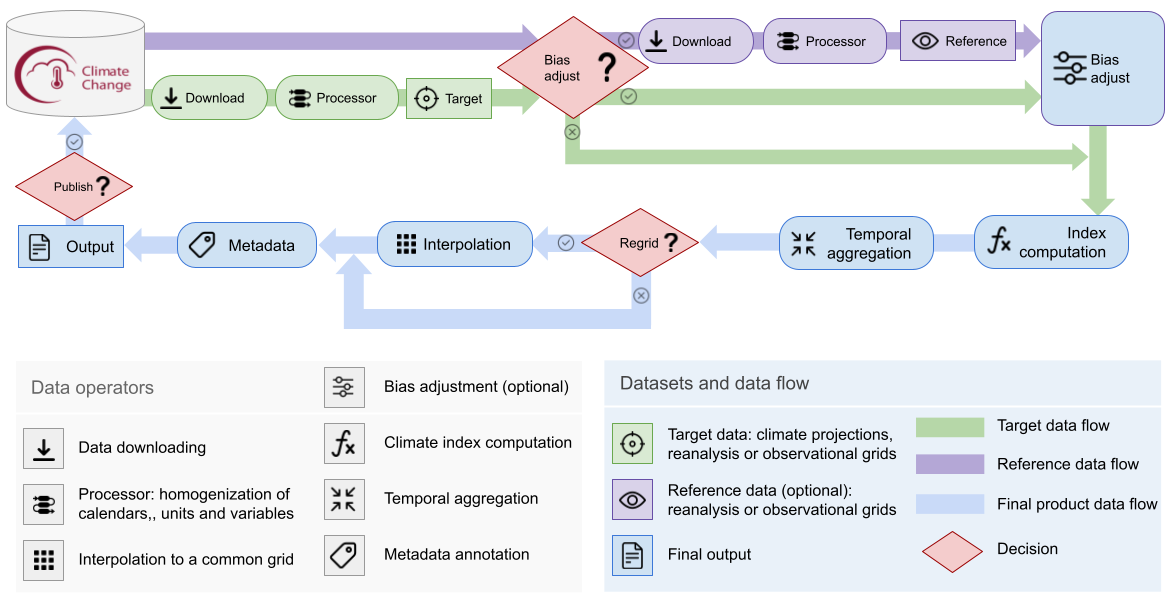

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Finding 1: will be a statement on the findings regarding the consistency 
* Finding 2
* Finding 3
* etc
```

## 📋 Methodology
This quality assessment tests the consistency between climate indicators retrieved from the [_Gridded dataset underpinning the Copernicus Interactive Climate Atlas_](https://doi.org/10.24381/cds.h35hb680) [[AtlasData](https://doi.org/10.24381/cds.h35hb680)] and their equivalents calculated from the origin datasets,
as well as the reproducibility of said dataset.

This notebook probes the consistency between the Atlas dataset and multiple origin datasets at the same time.
Due to differences in scope (e.g. atmosphere / land / sea), not every indicator is available in every origin dataset or its Atlas derivative.
Furthermore, some origin datasets are historical while others are future projections.
For this reason, we will examine the following indicators in the following origin datasets:

| Type               | Dataset       | Indicator |
|--------------------|---------------|-----------|
| Climate Projection | CMIP6         | Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C (`tx35`)
| Climate Projection | CMIP5         | Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C (`tx35`)
| Climate Projection | CORDEX-CORE   | Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C (`tx35`)
| Climate Projection | CORDEX-EUR-11 | Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C (`tx35`)
| Reanalysis         | ERA5          | Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C (`tx35`)
| Reanalysis         | ERA5-Land     | Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C (`tx35`)
| Reanalysis         | ORAS5         | Monthly mean temperature of sea water near the surface (`sst`)
| Reanalysis         | CERRA         | Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C (`tx35`)
| Observations       | E-OBS         | Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C (`tx35`)
| Observations       | BERKEARTH     | Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C (`tx35`)
| Observations       | CPC           | Monthly count of days with daily accumulated precipitation of liquid water equivalent from all phases above 1 mm (`r01`)
| Observations       | SST-CCI       | Monthly mean temperature of sea water near the surface (`sst`)

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-codesetup)**
 * Install User-tools for the C3S Atlas.
 * Import all required libraries.
 * Definition of helper functions.

**[](section-origin)**
 * Download data from the origin dataset(s).
 * Homogenise data.
 * Calculate indicator(s).
 * Interpolate to a common and regular grid.

**[](section-atlas)**
 * Download data from the Atlas dataset.

**[](section-results)**
 * Consistency: Compare the Atlas and reproduced datasets on native grids.
 * Reproducibility: Compare the Atlas and reproduced datasets on the Atlas grid.

## 📈 Analysis and results

(section-codesetup)=
### 1. Code setup
```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for 
downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data)) 
and visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data.
Because earthkit is in active development, some functionality may change after this notebook is published.
If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Install the User-tools for the C3S Atlas
This notebook uses the [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas), which can be installed from GitHub using `pip`.
For convenience, the following cell can do this from within the notebook.
Further details and alternative options for installing this library are available in its [documentation](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements).

In [1]:
!pip install git+https://github.com/ecmwf-projects/c3s-atlas.git

  Cloning https://github.com/ecmwf-projects/c3s-atlas.git to /tmp/pip-req-build-52khvyd0
  Running command git clone --filter=blob:none --quiet https://github.com/ecmwf-projects/c3s-atlas.git /tmp/pip-req-build-52khvyd0
  Resolved https://github.com/ecmwf-projects/c3s-atlas.git to commit 80256810cb81aa78ab53033479e08cff6a8add44
  Preparing metadata (setup.py) ... done


#### Import required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [2]:
# works
# Input / Output
from pathlib import Path
import earthkit.data as ekd

# General data handling
import numpy as np
import pandas as pd
import xarray as xr
from functools import partial

# Data pre-processing
from c3s_atlas.fixers import apply_fixers
import c3s_atlas.interpolation as xesmfCICA
from datetime import datetime

# Climate indicators
import xclim
xclim.set_options(cf_compliance="log")  # Mute warnings
import c3s_atlas.indexes
from c3s_atlas.units import VALID_UNITS

# Visualisation
import earthkit.plots as ekp
from earthkit.plots.styles import Style
import matplotlib.pyplot as plt
plt.rcParams["grid.linestyle"] = "--"
from tqdm import tqdm  # Progress bars

# Visualisation in Jupyter book -- automatically ignored otherwise
try:
    from myst_nb import glue
except ImportError:
    glue = None

/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


#### Define indicators

In [3]:
# works
def cal_tx35(ds):
    """ Monthly count of days with maximum near-surface (2-metre) temperature above 35 °C """
    ds_tx35 = xclim.indices.tx_days_above(ds['tasmax'], thresh='35.0 degC', freq='MS', op='>').to_dataset(name='tx35')
    return ds_tx35

def cal_sst(ds):
    """ Monthly mean temperature of sea water near the surface """
    ds_sst = ds['sst'].resample(time='MS').mean().to_dataset(name='sst')
    return ds_sst

def cal_r01(ds):
    """ Monthly count of days with daily accumulated precipitation of liquid water equivalent from all phases above 1 mm """
    pr_flux = ds['pr'].copy().assign_attrs(units = 'mm/day')
    per0 = xr.zeros_like(pr_flux).assign_attrs(units='mm/day')
    ds_r01 = xclim.indices.days_over_precip_thresh(pr_flux, per0, thresh='1 mm/day', freq='MS', bootstrap=False, op='>').to_dataset(name='r01')
    return ds_r01

In [4]:
# Styles for indicators
n_diff = 5  # Levels in difference charts

_style_monthly_days      = {"vmin": 0,     "vmax": 30,    "extend": "neither"}
_style_monthly_days_diff = {"vmin": -2.5,  "vmax": 2.5,   "extend": "both"}

# tx35 indicator
_style_tx35      = _style_monthly_days      | {"cmap": plt.cm.Oranges.resampled(10)}
_style_tx35_diff = _style_monthly_days_diff | {"cmap": plt.cm.RdBu_r.resampled(n_diff)}

# sst indicator
_style_sst        = {"cmap": plt.cm.YlOrBr.resampled(10),   "vmin": -5, "vmax": 45, "extend": "both"} # change numbers to reflect temps
_style_sst_diff   = {"cmap": plt.cm.RdBu.resampled(n_diff), "vmin": -2, "vmax": 2,  "extend": "both"}

# r01 indicator
_style_r01         = _style_monthly_days      | {"cmap": plt.cm.Blues.resampled(10)} # CHANGE ASK OB
_style_r01_diff    = _style_monthly_days_diff | {"cmap": plt.cm.RdBu.resampled(n_diff)}

# Individual styles
# Set up like this so they can still be edited individually
styles = {
    "tx35": Style(**_style_tx35),       "tx35_diff": Style(**_style_tx35_diff),
    "sst" : Style(**_style_sst),        "sst_diff": Style(**_style_sst_diff),
    "r01": Style(**_style_r01),         "r01_diff": Style(**_style_r01_diff),
}

# Apply general settings
for style in styles.values():
    style.normalize = False

#### Helper functions

##### General

In [5]:
# works
# Type hints
from typing import Iterable, Optional
from earthkit.plots.geo.domains import Domain
AnyDomain = (Domain | str)

##### Downloading data

In [6]:
# works
# Download Atlas data
def select_model_from_atlas_dataset(data: xr.Dataset, model: str) -> xr.Dataset:
    """ Select only data for the given model. """
    # Ensure the model ID is provided in the right format
    model_id = model.replace("_", "-").lower()

    # Find the corresponding model ID in the list of models
    # This cannot use .sel because the coordinate is not indexed
    select_member = [str(mem) for mem in data.member_id.values if model_id in mem.replace("_", "-").lower()][0]

    # Find the corresponding data and return those
    member_ind = np.where(data.member_id == select_member)[0]
    data_member = data.sel(member=member_ind).squeeze("member")

    return data_member

# Select (multiple) years in a dataset
def select_years_in_dataset(data: xr.Dataset, years: list[int]) -> xr.Dataset:
    """ Select only data for the given year(s). """
    years_int = [int(y) for y in years]
    return data.sel(time=data.time.dt.year.isin(years_int))

def _download_atlas_single(request: Iterable[dict], model: Optional[str] = None) -> xr.Dataset:
    """ Helper function for download_atlas_data_oneyear_onemember; download and process a single Atlas request. """
    # Download data
    ATLAS_ID = "multi-origin-c3s-atlas"
    ds = ekd.from_source("cds", ATLAS_ID, request)
    data = ds.to_xarray(compat="equals")
    
    # Drop "bnds" variables which can mess with merge later on
    bnds = [var for var in data.data_vars if var.endswith("_bnds")]
    data = data.drop_vars(bnds)

    # Select model for the origins with multiple
    if request['origin'] == "cmip5":
        data = select_model_from_atlas_dataset(data, "access1_0")

    if request['origin'] == "cmip6":
        data = select_model_from_atlas_dataset(data, "cmcc_esm2")

    if request['origin'] == "cordex_core":
        data = select_model_from_atlas_dataset(data, "NCC_NorESM1-M_REMO")
        

    # Select the correct single year
    if request['origin'] in ("cmip5", "cmip6", "cordex_core"):
        data = select_years_in_dataset(data, YEARS_FUTURE)    
    if request['origin'] in ("e_obs", "era5", "era5_land", "in_situ_temperature", 
                             "satellite_sea_surface_temperature", "oras5", "in_situ_precipitation"):
        data = select_years_in_dataset(data, YEARS_HISTORICAL)   
        
    return data

    
# DEFAULT_YEARS_BY_ORIGIN = {
#     # future group
#     "cmip5": YEARS_FUTURE,
#     "cmip6": YEARS_FUTURE,
#     "cordex_core": YEARS_FUTURE,

#     # historical group
#     "e_obs": YEARS_HISTORICAL,
#     "era5": YEARS_HISTORICAL,
#     "era5_land": YEARS_HISTORICAL,
#     "in_situ_temperature": YEARS_HISTORICAL,
#     "satellite_sea_surface_temperature": YEARS_HISTORICAL,
#     "oras5": YEARS_HISTORICAL,
#     "in_situ_precipitation": YEARS_HISTORICAL,
# }


In [7]:
# works
# Create requests for multiple daily / monthly variables
def create_requests_for_origins(main_request: dict, origins: Iterable[str]) -> dict:
    """ Given a `main_request`, add all missing entries for every origin. """
    requests = [(main_request | req) for req in origins]
    return requests

In [8]:
# works
def create_requests_for_months(main_request: dict, month_req: dict) -> dict:
    """ Given a `main_request`, add all the monthly entery. """
    requests = (main_request | month_req) #for req in month_requests]
    return requests


##### Data (pre-)processing

In [9]:
# Homogenisation of origin dataset
def homogenise(ds: xr.Dataset, var_name: str, project_id: str) -> xr.Dataset:
    """ Homogenise a dataset `ds` for one variable `var_name` """
    var_mapping = {
                "dataset_variable": {var_name: "data"},
                "aggregation": {"data": "mean"},
        }
    data = apply_fixers(ds, var_name, project_id, var_mapping)
    return data

In [10]:
# Interpolation from native grid to Atlas grid
def interpolation(ds: xr.Dataset, var_name: str, res: float) -> xr.Dataset:
    """ Interpolates a dataset, ds, for one variable, var_name """
    int_attr = {'interpolation_method': 'conservative_normed', 
                'lats': np.arange(-89.5, 90.5, res),
                'lons': np.arange(-179.5, 180.5, res),
                'var_name': var_name,
    }
    INTER = xesmfCICA.Interpolator(int_attr)
    ds_interp = INTER(ds)
    return ds_interp

#### Statistics

In [11]:
## Statistics
# Difference between datasets
def difference_between_datasets(data1: xr.Dataset, data2: xr.Dataset, diff_variables: Iterable[str]) -> xr.Dataset:
    """ Calculate the difference between two datasets, preserving CRS and metadata. """
    # Subtract
    data1, data2 = [d.drop_vars(["lat_bnds", "lon_bnds", "time_bnds", "height"], errors="ignore") for d in (data1, data2)]
    difference = xr.ufuncs.subtract(data1, data2)
    return difference

##### Visualisations

In [12]:
# works
# Select one month in multiple datasets
def select_month_in_multiple_datasets(*data: xr.Dataset, month: int=8) -> list[xr.Dataset]:
    """ Select only data for the given month, in any year. """
    data_month = [d.groupby("time.month")[month] for d in data]
    return data_month

def _spatial_plot_append_subplots(fig: ekp.Figure, *data: xr.Dataset, domain: Optional[AnyDomain]=None, **kwargs) -> list[ekp.Subplot]:
    """ Plot any number of datasets into new subplots in an existing earthkit figure. """
    # Create subplots
    subplots = [fig.add_map(domain=domain) for d in data]

    # Plot
    for subplot, d in zip(subplots, data):
        subplot.grid_cells(d, **kwargs)

    return subplots

(section-origin)=
### 2. Calculate indicators from the origin datasets

#### Download data
This notebook uses [earthkit-data](https://github.com/ecmwf/earthkit-data) to download files from the CDS.
If you intend to run this notebook multiple times, it is highly recommended that you [enable caching](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.

The first step is to define the parameters that will be shared between the downloads of the various origin datasets and the Atlas dataset (in the [next section](section-atlas)).
Next,
for each individual origin dataset,
the request to download the corresponding data from the CDS is defined.

#### Homogenise data
One of the steps in the Atlas dataset production chain is homogenisation, i.e. ensuring consistency between data from different origin datasets.
This homogenisation is implemented in the [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas/tree/main/c3s_atlas), specifically the `c3s_atlas.fixers.apply_fixers` function.
The following changes are applied:

- The names of the spatial coordinates are standardised to `[lon, lat]`.
- Longitude is converted from `[0...360]` to `[-180...180]` format.
- The time coordinate is standardised to the CF standard calendar.
- Variable units are standardised (e.g. °C for temperature).
- Variables are resampled / aggregated to the required temporal resolution.

The homogenisation is applied in the following code cell.
The `apply_fixers` function describes the different homogenisation steps as it applies them;
this can be read by expanding the following cell outputs.

#### Calculate indicators
The climate indicators
are calculated using [xclim](https://xclim.readthedocs.io/en/stable/).
The functions defined [above](section-codesetup) perform the calculations.

#### Interpolate to a common and regular grid
```{note}
This notebook uses [xESMF](https://github.com/pangeo-data/xESMF) for regridding data.
xESMF is most easily installed using mamba/conda as explained in its documentation.
Users who cannot or do not wish to use mamba/conda can manually compile and install [ESMF](https://earthsystemmodeling.org/docs/release/latest/ESMF_usrdoc/node10.html) on their machines.
In future, this notebook will use [earthkit-regrid](https://github.com/ecmwf/earthkit-regrid) instead, once it reaches suitable maturity.
```

The final step in the processing is regridding and interpolation to a standard grid (Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q01_workflow-fig>`).
This is performed through a custom function in the [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas/tree/main/c3s_atlas),
specifically `c3s_atlas.interpolation`.
This function is based on ESMF, as noted above.

Note that the Atlas workflow calculates indicators first, then regrids.
For operations that involve averaging, like smoothing and regridding, the order of operations can affect the result, especially in areas with steep gradients [[Bur20](https://doi.org/10.1364/OE.391470)].
Examples of such areas for a temperature index are coastlines and mountain ranges.
In the case of Atlas, this order of operations was a conscious choice to preserve the "raw" signals,
e.g. preventing extreme temperatures from being smoothed out.
However, it can affect the indicator values and therefore must be considered when using the Atlas application or dataset.

Due to the number of datasets involved, this section can take several minutes to run.

In [13]:
# works
# General setup
YEARS_HISTORICAL = ["2010"]
YEARS_FUTURE = ["2080"]
MONTHS = [f"{month:02d}" for month in range(1, 13)]
DAYS = [f"{day:02d}" for day in range(1, 32)]

In [14]:
# works
# Download CMIP5 data
CMIP5_ID = "projections-cmip5-daily-single-levels"
CMIP5_MODEL = "access1_0"
request_CMIP5 = {
    "experiment": "rcp_8_5",
    "variable": ["maximum_2m_temperature_in_the_last_24_hours"],
    "model": CMIP5_MODEL,
    "ensemble_member": "r1i1p1",
    "period": ["20560101-20801231"]
}

data = ekd.from_source("cds", CMIP5_ID, request_CMIP5).to_xarray()
data = select_years_in_dataset(data, YEARS_FUTURE)
data = homogenise(data, "tasmax", CMIP5_ID)
indicator_CMIP5 = cal_tx35(data)
interpolated_CMIP5 = interpolation(indicator_CMIP5, "tx35", 2)


2025-10-06 10:26:05,051 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-10-06 10:26:05,056 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 41MB
Dimensions:    (time: 366, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2080-01-01T12:00:00 ... 2080-12-31T1...
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 6kB dask.array<chunksize=(366, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(145, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 41MB dask.array<chunksize=(366, 145, 192), meta=np.ndarray>
Attributes: (12/28)
   

In [15]:
# works
# Download CMIP6 data
CMIP6_ID = "projections-cmip6"
CMIP6_MODEL = "cmcc_esm2"
request_CMIP6 = {
    "temporal_resolution": "daily",
    "experiment": "ssp5_8_5",
    "model": CMIP6_MODEL,
    "variable": ["daily_maximum_near_surface_air_temperature"],
    "year": YEARS_FUTURE,
    "month": MONTHS,  
    "day": DAYS,
}

data = ekd.from_source("cds", CMIP6_ID, request_CMIP6).to_xarray()
data = homogenise(data, "tasmax", CMIP6_ID)
indicator_CMIP6 = cal_tx35(data)
interpolated_CMIP6 = interpolation(indicator_CMIP6, "tx35", 1)


Unknown file type, no reader available. path=/home/nr2/cdsdata/cds-1d1e09b3e5d812f291bbbebd86557b1332c1396bccf637551cdadffd57817d6f.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\n\xd3\x00\x00\x03"\x08\x02\x00\x00\x00\x99\xec9+\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None
2025-10-06 10:26:12,898 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-10-06 10:26:12,904 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 81MB
Dimensions:    (time: 365, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 3kB 2080-01-01 12:00:00 ... 2080-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) obj

In [16]:
# works
# Download CORDEX EUR 11 data
CORDEX_EUR_11_ID = "projections-cordex-domains-single-levels"
CORDEX_EUR_11_MODEL = "NCC_NorESM1-M_REMO"
request_CORDEX_EUR_11 = {
    "domain": "europe",
    "experiment": "rcp_8_5",
    "horizontal_resolution": "0_11_degree_x_0_11_degree",
    "temporal_resolution": "daily_mean",
    "variable": ["maximum_2m_temperature_in_the_last_24_hours"],
    "gcm_model": "ncc_noresm1_m",
    "rcm_model": "gerics_remo2015",
    "ensemble_member": "r1i1p1",
    "start_year": ["2076"],
    "end_year": ["2080"]
}

data = ekd.from_source("cds", CORDEX_EUR_11_ID, request_CORDEX_EUR_11).to_xarray()
data = select_years_in_dataset(data, YEARS_FUTURE)
data = homogenise(data, "tasmax", CORDEX_EUR_11_ID)
indicator_CORDEX_EUR_11 = cal_tx35(data)
interpolated_CORDEX_EUR_11 = interpolation(indicator_CORDEX_EUR_11, "tx35", 0.25)

2025-10-06 10:26:18,828 — Homogenization-fixers — INFO — Fixing coordinates names: {'rlon': 'x', 'rlat': 'y'}
2025-10-06 10:26:18,832 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 263MB
Dimensions:                     (time: 366, bnds: 2, y: 412, x: 424, vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 3kB 2080-01-01T12:00:00...
  * y                           (y) float64 3kB -23.38 -23.27 ... 21.72 21.84
  * x                           (x) float64 3kB -28.38 -28.27 ... 18.04 18.16
    lat                         (y, x) float32 699kB dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon                         (y, x) float32 699kB dask.array<chunksize=(412, 424), meta=np.ndarray>
    height                      float64 8B ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    rotated_latitude_longi

In [17]:
# works
# Download E-OBS data
E_OBS_ID = "insitu-gridded-observations-europe"
request_E_OBS = {
    "product_type": "ensemble_mean",
    "variable": ["maximum_temperature"],
    "grid_resolution": "0_25deg",
    "period": "full_period",
    "version": ["30_0e"]
}

data = ekd.from_source("cds", E_OBS_ID, request_E_OBS).to_xarray()
data = select_years_in_dataset(data, YEARS_HISTORICAL)

# preprocessing for homogenisation 
data = data.rename({"tx": "tasmax"})

data = homogenise(data, "tasmax", E_OBS_ID)
indicator_E_OBS = cal_tx35(data)
interpolated_E_OBS = interpolation(indicator_E_OBS, "tx35", 0.125)

2025-10-06 10:26:41,494 — Homogenization-fixers — INFO — Fixing coordinates names: {'longitude': 'lon', 'latitude': 'lat'}
2025-10-06 10:26:41,497 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 136MB
Dimensions:  (time: 365, lat: 201, lon: 464)
Coordinates:
  * lat      (lat) float64 2kB 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
  * lon      (lon) float64 4kB -40.38 -40.12 -39.88 -39.62 ... 74.88 75.12 75.38
  * time     (time) datetime64[ns] 3kB 2010-01-01 2010-01-02 ... 2010-12-31
Data variables:
    tasmax   (time, lat, lon) float32 136MB dask.array<chunksize=(1, 201, 464), meta=np.ndarray>
Attributes:
    E-OBS_version:  30.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Aug 30 12:47:29 2024: ncks --no-abc -d time,0,27209 /...
    NCO:            netCDF Operators version 5.1.8 (Homepage = http://nco.sf....
2025-10-06 10:26:41,507 — UNITS_TRANSFORM — INFO — The dat

In [27]:
# works
# Download ERA data
ERA5_ID = "reanalysis-era5-single-levels"
request_ERA5 = {
    "product_type": ["reanalysis"],
    "variable": ["maximum_2m_temperature_since_previous_post_processing"],
    "year": YEARS_HISTORICAL,
    "month": MONTHS,  
    "day": DAYS,
    "data_format": "netcdf",
    "download_format": "unarchived",
}

data = ekd.from_source("cds", ERA5_ID, request_ERA5).to_xarray()

# preprocessing for homogenisation 
data = data.rename({"valid_time": "time"})   
data = data.rename({"mx2t": "tasmax"})  

data = homogenise(data, "tasmax", ERA5_ID)
indicator_ERA5 = cal_tx35(data)
interpolated_ERA5 = interpolation(indicator_ERA5, "tx35", 0.25)


2025-10-06 10:53:55,939 — Homogenization-fixers — INFO — Fixing coordinates names: {'longitude': 'lon', 'latitude': 'lat'}
2025-10-06 10:53:55,943 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 2GB
Dimensions:  (time: 365, lat: 721, lon: 1440)
Coordinates:
    number   int64 8B ...
  * time     (time) datetime64[ns] 3kB 2010-01-01T12:00:00 ... 2010-12-31T12:...
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    expver   (time) <U4 6kB dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    tasmax   (time, lat, lon) float32 2GB dask.array<chunksize=(73, 145, 288), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Fore

In [28]:
# works
# Download ERA-Land data
ERA5_Land_ID = "derived-era5-land-daily-statistics"  
request_ERA5_Land = {
    "variable": ["2m_temperature"],
    "year": YEARS_HISTORICAL,
    "day": DAYS,
    "daily_statistic": "daily_maximum",
    "time_zone": "utc+00:00",
    "frequency": "1_hourly",
}

# Do monthly request as yearly request exceeds CDS limits
request_month_ERA5_Land = [{"month": [f"{month:02d}"]} for month in range(1, 13)]    
requests_monthly_era5_land = [create_requests_for_months(request_ERA5_Land, month) for month in request_month_ERA5_Land]

# Combinbe 
data = ekd.from_source("cds", ERA5_Land_ID, *requests_monthly_era5_land).to_xarray()

# preprocessing for homogenisation 
data = data.rename({"valid_time": "time"}) 
data = data.rename({"t2m": "tasmax"})  

data = homogenise(data, "tasmax", ERA5_Land_ID)
indicator_ERA5_Land = cal_tx35(data)
interpolated_ERA5_Land = interpolation(indicator_ERA5_Land, "tx35", 0.1)


100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 255.87it/s]
2025-10-06 10:54:53,753 — Homogenization-fixers — INFO — Fixing coordinates names: {'longitude': 'lon', 'latitude': 'lat'}
2025-10-06 10:54:53,757 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 9GB
Dimensions:  (time: 365, lat: 1801, lon: 3600)
Coordinates:
    number   int64 8B 0
  * lat      (lat) float64 14kB 90.0 89.9 89.8 89.7 ... -89.7 -89.8 -89.9 -90.0
  * lon      (lon) float64 29kB 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * time     (time) datetime64[ns] 3kB 2010-01-01 2010-01-02 ... 2010-12-31
Data variables:
    tasmax   (time, lat, lon) float32 9GB dask.array<chunksize=(8, 451, 900), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European 

In [20]:
# works
# Download BERKEARTH data
BERKEARTH_ID = "insitu-gridded-observations-global-and-regional"
request_BERKEARTH = {
    "origin": "berkearth",
    "region": "global",
    "variable": ["temperature_anomaly"],
    "statistic": ["maximum"],
    "time_aggregation": "daily",
    "horizontal_aggregation": ["1_x_1"],
    "year": YEARS_HISTORICAL,
    "version": ["v1_0"]
}

data = ekd.from_source("cds", BERKEARTH_ID, request_BERKEARTH).to_xarray()

# preprocessing for homogenisation 
data["tasmax"].attrs["units"] = "Celsius"

data = homogenise(data, "tasmax", BERKEARTH_ID)
indicator_BERKEARTH = cal_tx35(data)
interpolated_BERKEARTH = interpolation(indicator_BERKEARTH, "tx35", 1)

2025-10-06 10:37:12,441 — Homogenization-fixers — INFO — Fixing coordinates names: {'longitude': 'lon', 'latitude': 'lat'}
2025-10-06 10:37:12,450 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 95MB
Dimensions:  (time: 365, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2010-01-01 2010-01-02 ... 2010-12-31
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    tasmax   (time, lat, lon) float32 95MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/21)
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    institution:                Berkeley Earth Surface Temperature Project
    Conventions:                Berkeley Earth Internal Convention (based on ...
    title:                      Gridded Berkeley Earth Surface Temperature An...
    source_history:        

In [21]:
# works
# Download ORAS5 data
ORAS5_ID = "reanalysis-oras5"
request_ORAS5 = {
    "product_type": ["consolidated"],
    "vertical_resolution": "single_level",
    "variable": ["sea_surface_temperature"],
    "year": YEARS_HISTORICAL,
    "month": MONTHS,
}

data = ekd.from_source("cds", ORAS5_ID, request_ORAS5).to_xarray()

# preprocessing for homogenisation 
data = data.rename({"sosstsst": "sst"})   
data["sst"].attrs["units"] = "Celsius"    

data = homogenise(data, "sst", ORAS5_ID)
indicator_ORAS5 = cal_sst(data)
interpolated_ORAS5 = interpolation(indicator_ORAS5, "sst", 0.05)

2025-10-06 10:37:17,988 — Homogenization-fixers — INFO — Fixing coordinates names: {'nav_lon': 'lon', 'nav_lat': 'lat'}
2025-10-06 10:37:18,011 — UNITS_TRANSFORM — INFO — The dataset sst units are already in the correct magnitude
2025-10-06 10:37:18,055 — Homogenization-fixers — INFO — The dataset is in daily or monthly resolution, we don't need to resample it from hourly frequency
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:450: PerformanceWarning: Regridding is increasing the number of chunks by a factor of 80.0, you might want to specify sizes in `output_chunks` in the regridder call. Default behaviour is to preserve the chunk sizes from the input (511, 721).
  result_vars[name] = func(*variable_args)
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13

In [22]:
# Download SST_CCI data 
# Generate valid daily requests for a given year
def generate_valid_daily_requests(year: int):
    """ Given a `year`, generate valid dates. """
    valid_requests = []
    for month in range(1, 13):
        for day in range(1, 32):
            try:
                # Validate the date
                datetime(year, month, day)
                valid_requests.append({
                    "month": [f"{month:02d}"],
                    "day": [f"{day:02d}"]
                })
            except ValueError:
                continue  # Skip invalid dates
    return valid_requests

# Main request
SST_CCI_ID = "satellite-sea-surface-temperature-ensemble-product"
request_main_SST_CCI = {
    "variable": "all",
    "year": YEARS_HISTORICAL,
}

# Generate only valid dates
requests_daily_SST_CCI = generate_valid_daily_requests(2010)

# Merge main and daily requests
def create_requests_for_daily(main_request: dict, daily_req: dict) -> dict:
    """ Given a `main_request`, add all the `daily_req` (consists of day and month value). """
    return main_request | daily_req

requests_full_daily_SST_CCI = [
    create_requests_for_daily(request_main_SST_CCI, daily_request)
    for daily_request in requests_daily_SST_CCI
]

# Download and select variable
def download_select_data(request: dict, variable: str):
    """ Given a `request`, download the data, and select the required `variable`. """
    ds_SST_CCI = ekd.from_source("cds", SST_CCI_ID, *request)
    ds_SST_CCI = ds_SST_CCI.to_xarray()
    return ds_SST_CCI[[variable]]


data = download_select_data(requests_full_daily_SST_CCI, "analysed_sst")

# preprocessing for homogenisation 
data = data.rename({"analysed_sst": "sst"}) 
data["sst"].attrs["units"] = "Kelvin"  

data = homogenise(data, "sst", SST_CCI_ID)
indicator_SST_CCI= cal_sst(data)
interpolated_SST_CCI = interpolation(indicator_SST_CCI, "sst", 0.25)

100%|██████████████████████████████████████████████████████████████████████| 365/365 [00:01<00:00, 305.96it/s]
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  return xr.open_mfdataset(
2025-10-06 10:48:31,506 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-10-06 10:48:31,523 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 2GB
Dimensions:  (time: 365, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2010-01-01T12:00:00 ... 2010-12-31T12:...
  *

In [23]:
# works
# Download CPC data 
CPC_ID = "insitu-gridded-observations-global-and-regional"
request_CPC = {
    "origin": "cpc",
    "region": "global",
    "variable": ["precipitation"],
    "time_aggregation": "daily",
    "horizontal_aggregation": ["0_5_x_0_5"],
    "year": YEARS_HISTORICAL,
    "version": ["v1_0"]
}

data = ekd.from_source("cds", CPC_ID, request_CPC).to_xarray()

# Preprocessing for homogenisation 
data["pr"].attrs["units"] = "mm day**-1" 

data = homogenise(data, "pr", CPC_ID)
indicator_CPC = cal_r01(data)
interpolated_CPC = interpolation(indicator_CPC, "r01", 0.5)

2025-10-06 10:49:27,712 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-10-06 10:49:27,717 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 757MB
Dimensions:  (time: 365, lat: 360, lon: 720)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2010-01-01T12:00:00 ... 2010-12-31T12:...
  * lon      (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    pr       (time, lat, lon) float64 757MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/19)
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    institution:                NOAA/NCEP/CPC (converted to netcdf at KNMI)
    Conventions:                CF-1.4
    NCO:                        netCDF Operators version 4.9.0 (Homepage = ht...
    title:                      CPC unified (gauge-based) precipitatio

In [30]:
# Delete no longer needed objects 
del data 

# Put the indicator datasets and the interpolated datasets into dictionaries by indicator for easy access later 
indicator_tx35 = {
    "CMIP5": indicator_CMIP5,
    "CMIP6": indicator_CMIP6,
    "CORDEX_EUR_11": indicator_CORDEX_EUR_11,
    "E_OBS": indicator_E_OBS,
    "ERA5": indicator_ERA5,
    "ERA5_Land": indicator_ERA5_Land,
    "BERKEARTH": indicator_BERKEARTH,
}
   
dataset_tx35 = {
    "CMIP5": interpolated_CMIP5,
    "CMIP6": interpolated_CMIP6,
    "CORDEX_EUR_11": interpolated_CORDEX_EUR_11,
    "E_OBS": interpolated_E_OBS,
    "ERA5": interpolated_ERA5,
    "ERA5_Land": interpolated_ERA_Land,
    "BERKEARTH": interpolated_BERKEARTH,
}

indicator_sst = {
    "SST_CCI": indicator_SST_CCI,
    "ORAS5": indicator_ORAS5,
    
}

dataset_sst = {
    "SST_CCI": interpolated_SST_CCI,
    "ORAS5": interpolated_ORAS5,
}

indicator_r01 = {
    "CPC": indicator_CPC,
}

dataset_r01 = {
    "CPC": interpolated_CPC,
}

(section-atlas)= 
### 3. Retrieve indicator(s) from the Atlas dataset
Here, we download the same indicators as above directly from the [Gridded dataset underpinning the Copernicus Interactive Climate Atlas](https://doi.org/10.24381/cds.h35hb680) so the values can be compared.

When downloading the Atlas dataset from the CDS, it is not possible to specify a specific year or model like it is for e.g. CMIP6.
Instead, data are downloaded in blocks of several decades and include all model members.
To prevent memory issues from loading so many data at once,
a custom function is used that downloads the data for each indicator and pulls out only the year and model member of interest.
Because this is done in sequence
(one dataset after another)
rather than in parallel (all at the same time, like a normal earthkit-data download),
this can result in the following cells taking relatively long (>1 hour) to run the first time.
After the first time, caching in earthkit-data will (if enabled) speed this section up significantly.

In [31]:
# Setup: General request
ATLAS_ID = "multi-origin-c3s-atlas"
BIAS_ADJUSTMENT = "no_bias_adjustment"

In [32]:
# Main tx35 request
VARIABLE_TX35 = "monthly_extreme_hot_days"

request_atlas_tx35 = {
    "variable": VARIABLE_TX35,
    "bias_adjustment": BIAS_ADJUSTMENT,
}

In [33]:
# Origin tx35 requests
request_atlas_cmip5 = {
    "origin": "cmip5",
    "experiment": "rcp_8_5",
    "domain": "global",
    "period": "2006-2100",
}

request_atlas_cmip6 = {
    "origin": "cmip6",
    "experiment": "ssp5_8_5",
    "domain": "global",
    "period": "2015-2100"
}

request_cordex_eur_11 = {
    "origin": "cordex_core",
    "experiment": "rcp_8_5",
    "domain": "global_mosaic",
    "period": "2006-2100",
}

request_atlas_e_obs = {
    "origin": "e_obs",
    "domain": "europe",
    "period": "1950-2021",
}

request_atlas_era5 = {
    "origin": "era5",
    "domain": "global",
    "period": "1940-2024",
}

request_atlas_era5_land = {
    "origin": "era5_land",
    "domain": "global",
    "period": "1950-2024",
}
    
request_atlas_berkearth = {
    "origin": "in_situ_temperature",
    "domain": "global",
    "period": "1881-2017",
}

# Combine origin requests into a dictionary
request_tx35_dict = {
    "CMIP5": request_atlas_cmip5, 
    "CMIP6": request_atlas_cmip6, 
    "CORDEX_EUR_11": request_cordex_eur_11,
    "E_OBS": request_atlas_e_obs, 
    "ERA5": request_atlas_era5,
    "ERA5_LAND": request_atlas_era5_land,
    "BERKEARTH": request_atlas_berkearth
}    

# Join main request with origin requests
origins_tx35 = {key: (request | request_atlas_tx35) for key, request in request_tx35_dict.items()}

In [34]:
# Download tx35 Atlas data 
ds_atlas_origins_tx35 = {key: _download_atlas_single(request) for key, request in origins_tx35.items()}
ds_atlas_origins_tx35

Unknown file type, no reader available. path=/home/nr2/cdsdata/cds-e8eaa788d662b0b3b8ee47c058d766d3a23f4191500a1b669a3a4ecccf1b3ecb.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\xea\x00\x00\x03\x10\x08\x02\x00\x00\x00\x1c\xd4\x8f\xbe\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
Unknown file type, no reader available. path=/home/nr2/cdsdat

{'CMIP5': <xarray.Dataset> Size: 780kB
 Dimensions:          (time: 12, lat: 90, lon: 180)
 Coordinates:
   * lat              (lat) float64 720B -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
   * lon              (lon) float64 1kB -179.0 -177.0 -175.0 ... 177.0 179.0
   * time             (time) datetime64[ns] 96B 2080-01-01 ... 2080-12-01
     member_id        <U33 132B dask.array<chunksize=(), meta=np.ndarray>
     gcm_institution  <U12 48B dask.array<chunksize=(), meta=np.ndarray>
     gcm_model        <U13 52B dask.array<chunksize=(), meta=np.ndarray>
     gcm_variant      <U7 28B dask.array<chunksize=(), meta=np.ndarray>
     threshold35c     float64 8B ...
     height2m         float64 8B ...
 Data variables:
     tx35             (time, lat, lon) float32 778kB dask.array<chunksize=(12, 15, 30), meta=np.ndarray>
     crs              int32 4B ...
 Attributes: (12/26)
     Conventions:                CF-1.9 ACDD-1.3
     title:                      Copernicus Interactive Climate Atlas: gr

In [35]:
# Main sst request
VARIABLE_SST = "monthly_sea_surface_temperature"
DOMAIN_SST = "global"

request_atlas_sst = {
    "variable": VARIABLE_SST,
    "bias_adjustment": BIAS_ADJUSTMENT,
    "domain": DOMAIN_SST
}

In [36]:
# Origin sst requests
request_atlas_oras5 = {
    "origin": "oras5",
    "period": "1958-2014",
}

request_atlas_sst_cci = {
    "origin": "satellite_sea_surface_temperature",
    "period": "1982-2022",
}

# Combine origin requests into a dictionary
request_sst_dict = {
    "ORAS5": request_atlas_oras5, 
    "SST_CCI": request_atlas_sst_cci, 
}    

# Join main request with origin requests
origins_sst = {key: (request | request_atlas_sst) for key, request in request_sst_dict.items()}

In [37]:
# Download sst Atlas data
ds_atlas_origins_sst = {key: _download_atlas_single(request) for key, request in origins_sst.items()}
ds_atlas_origins_sst

Unknown file type, no reader available. path=/home/nr2/cdsdata/cds-aa7a913d3ff1f7ba2bf6b8e03935492b1c20f0307a4a0d0c3bf980648c788c77.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\x96\x00\x00\x03\x10\x08\x06\x00\x00\x00\x7f\xc3}\xff\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddy' content_type=None
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'sst' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'sst' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
Unknown file type, no reader available. path=/home/nr2/cdsdata/cds

{'ORAS5': <xarray.Dataset> Size: 50MB
 Dimensions:  (time: 12, lat: 720, lon: 1440)
 Coordinates:
   * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
   * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
   * time     (time) datetime64[ns] 96B 2010-01-01 2010-02-01 ... 2010-12-01
 Data variables:
     sst      (time, lat, lon) float32 50MB dask.array<chunksize=(12, 80, 160), meta=np.ndarray>
     crs      int32 4B ...
 Attributes: (12/25)
     Conventions:                CF-1.9 ACDD-1.3
     title:                      Copernicus Interactive Climate Atlas: gridded...
     summary:                    Monthly/annual gridded data from observations...
     institution:                Copernicus Climate Change Service (C3S)
     producers:                  Institute of Physics of Cantabria (IFCA, CSIC...
     license:                    CC-BY 4.0, https://creativecommons.org/licens...
     ...                         ...
     geospatial_lo

In [38]:
# Main r01 request
VARIABLE_R01 = "monthly_wet_days"

request_atlas_r01 = {
    "variable": VARIABLE_R01,
    "bias_adjustment": BIAS_ADJUSTMENT,
}

In [39]:
# Origin r01 request
request_atlas_cpc = {
    "origin": "in_situ_precipitation",
    "domain": "global",
    "period": "1979-2020",
}

# Combine origin requests into a dictionary
request_r01_dict = {
    "CPC": request_atlas_cpc, 
}    

# Join main request with origin requests
origins_r01 = {key: (request | request_atlas_r01) for key, request in request_r01_dict.items()}

In [40]:
# Download r01 Atlas data 
ds_atlas_origins_r01 = {key: _download_atlas_single(request) for key, request in origins_r01.items()}
ds_atlas_origins_r01

Unknown file type, no reader available. path=/home/nr2/cdsdata/cds-26eff080464806ef2adc46149cff127cefdf2f5f616d34496a68ac432e1f8afa.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08~\x00\x00\x03\x10\x08\x06\x00\x00\x00[\xf60z\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddy' content_type=None
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'r01' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'r01' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


{'CPC': <xarray.Dataset> Size: 12MB
 Dimensions:       (time: 12, lat: 360, lon: 720)
 Coordinates:
   * lat           (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
   * lon           (lon) float64 6kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
   * time          (time) datetime64[ns] 96B 2010-01-01 2010-02-01 ... 2010-12-01
     threshold1mm  float64 8B ...
 Data variables:
     r01           (time, lat, lon) float32 12MB dask.array<chunksize=(12, 90, 180), meta=np.ndarray>
     crs           int32 4B ...
 Attributes: (12/25)
     Conventions:                CF-1.9 ACDD-1.3
     title:                      Copernicus Interactive Climate Atlas: gridded...
     summary:                    Monthly/annual gridded data from observations...
     institution:                Copernicus Climate Change Service (C3S)
     producers:                  Institute of Physics of Cantabria (IFCA, CSIC...
     license:                    CC-BY 4.0, https://creativecommons.org/licens...
  

(section-results)=
### 4. Results
This section contains the comparison between the indicator values retrieved from the Atlas dataset vs those reproduced from the origin dataset.

The datasets are first compared on their native grids.
This means a point-by-point comparison is not possible
(because the points are not equivalent),
but the distributions can be compared geospatially and overall.
This comparison probes the consistency quality attribute:
Are the climate indicators in the dataset underpinning the Copernicus Interactive Climate Atlas consistent with their origin datasets?

The second comparison uses the regridded version of the indicators derived from the origin dataset.
This makes a point-by-point comparison possible.
This second comparison probes how well the dataset underpinning the Copernicus Interactive Climate Atlas can be reproduced from its origin datasets,
based on the workflow (Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q03_workflow-fig>`).

#### Consistency: Comparison on native grids

For the geospatial comparison, 
we display the values of the indicators for one month,
across one region and globally.
In the first example, we display the results across
Europe
in
June,
which should provide significant spatial variation.

This region can easily be modified in the following code cell using the [domains provided by earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/05-domains.html).
Some examples are provided in the cell (commented out using `#`).

In [41]:
# Setup: Choose a month to display
month = 6

# Setup: Pick domain using earthkit-plots
domain = "Europe"
# domain = "Mediterranean"

# Other examples -- uncomment where desired
# domain = ekp.geo.domains.union(["Portugal", "Spain"], name="Iberia")
# domain = ekp.geo.domains.union(["Ireland", "United Kingdom"], name="UK & Ireland")
# domain = "Italy"
# domain = "South America"

In [42]:
# Visualisation: Helper functions, general
def _glue_or_show(fig: plt.Figure, glue_label: Optional[str]=None) -> None:
    """
    If `glue` is available, glue the figure using the provided label.
    If not, display the figure in the notebook.
    """
    try:
        glue(glue_label, fig, display=False)
    except TypeError:
        plt.show()
    finally:
        plt.close()

def _add_textbox_to_subplots(text: str, *axs: Iterable[plt.Axes | ekp.Subplot], right=False) -> None:
    """ Add a text box to each of the specified subplots. """
    # Get the plt.Axes for each ekp.Subplot
    axs = [subplot.ax if isinstance(subplot, ekp.Subplot) else subplot for subplot in axs]

    # Set up location
    x = 0.95 if right else 0.05
    horizontalalignment = "right" if right else "left"

    # Add the text
    for ax in axs:
        ax.text(x, 0.95, text, transform=ax.transAxes,
        horizontalalignment=horizontalalignment, verticalalignment="top",
        bbox={"facecolor": "white", "edgecolor": "black", "boxstyle": "round",
              "alpha": 1})

def _sharexy(axs: np.ndarray) -> None:
    """ Force all of the axes in axs to share x and y with the first element. """
    main_ax = axs.ravel()[0]
    for ax in axs.ravel():
        ax.sharex(main_ax)
        ax.sharey(main_ax)

def _symmetric_xlim(ax: plt.Axes) -> None:
    """ Adjust the xlims for one Axes to be symmetric, based on existing values. """
    current = ax.get_xlim()
    current = np.abs(current)
    maxlim = np.max(current)
    newlim = (-maxlim, maxlim)

    ax.set_xlim(newlim)

In [43]:
# works # move to top when done
# Select one month in multiple datasets
def select_month_in_multiple_datasets(*data: xr.Dataset, month: int=8) -> list[xr.Dataset]:
    """ Select only data for the given month, in any year. """
    data_month = [d.groupby("time.month")[month] for d in data]
    return data_month



In [44]:
# Visualisation: Helper functions for geospatial plots
def _spatial_plot_append_subplots(fig: ekp.Figure, *data: xr.Dataset, domain: Optional[AnyDomain]=None, **kwargs) -> list[ekp.Subplot]:
    """ Plot any number of datasets into new subplots in an existing earthkit figure. """
    # Create subplots
    subplots = [fig.add_map(domain=domain) for d in data]

    # Plot
    for subplot, d in zip(subplots, data):
        subplot.grid_cells(d, **kwargs)

    return subplots

In [47]:
def geospatial_comparison_multiple_origin(data1: dict, data2: dict, indicator: str, month: int, *,
                                              label1: str="Atlas dataset", label2: str="Reproduced from origin",
                                              domain: Optional[str | Domain]=None) -> ekp.Figure:
    """
    Loop through the origins
    Plot a list of origins in two datasets
    Assumes the data are from a single year.
    A specific month has to be specified.
    """
    common_keys = [k for k in data1 if k in data2]
    n_datasets = len(common_keys)
    loop_indicators = tqdm(common_keys, desc="Plotting datasets", leave=False)
    
    # Create figure
    fig = ekp.Figure(rows=n_datasets, columns=2, size=(7.5, 3*n_datasets))
    
    for i, key in enumerate(loop_indicators):
        data_1 = data1[key]
        data_2 = data2[key]
        data1_month, data2_month = select_month_in_multiple_datasets(data_1, data_2, month = month)
        # Plot individual datasets
        subplots_data = _spatial_plot_append_subplots(fig, data1_month, data2_month, domain=domain, 
                                                      z=indicator, style=styles[indicator])
        
        year1 = int(data1_month.time.dt.year.values[0])
        year2 = int(data2_month.time.dt.year.values[0])
        if year1 != year2:
            raise ValueError(f"Expected the same year, got {year1} and {year2}")

        # Decorate: Text + Colour bar
        _add_textbox_to_subplots(f"{key} ({year1})", *subplots_data)
        _add_textbox_to_subplots
        subplots_data[-1].legend(label=indicator, location="right")

    # Titles on top
    titles = [label1, label2]
    for title, subplot in zip(titles, fig.subplots):
        subplot.ax.set_title(title)

    # Decorate figure
    fig.land()
    fig.coastlines()
    fig.gridlines(linestyle=plt.rcParams["grid.linestyle"])
    
    plt.show()

   
    return fig

In [51]:
indicator_tx35["CORDEX_EUR_11"]

<xarray.Dataset> Size: 18MB
Dimensions:  (y: 412, x: 424, time: 12)
Coordinates:
  * y        (y) float64 3kB -23.38 -23.27 -23.16 -23.05 ... 21.61 21.72 21.84
  * x        (x) float64 3kB -28.38 -28.27 -28.16 -28.05 ... 17.93 18.04 18.16
    lat      (y, x) float32 699kB dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon      (y, x) float32 699kB dask.array<chunksize=(412, 424), meta=np.ndarray>
    height   float64 8B 2.0
  * time     (time) datetime64[ns] 96B 2080-01-01 2080-02-01 ... 2080-12-01
Data variables:
    tx35     (time, y, x) int64 17MB dask.array<chunksize=(1, 412, 424), meta=np.ndarray>

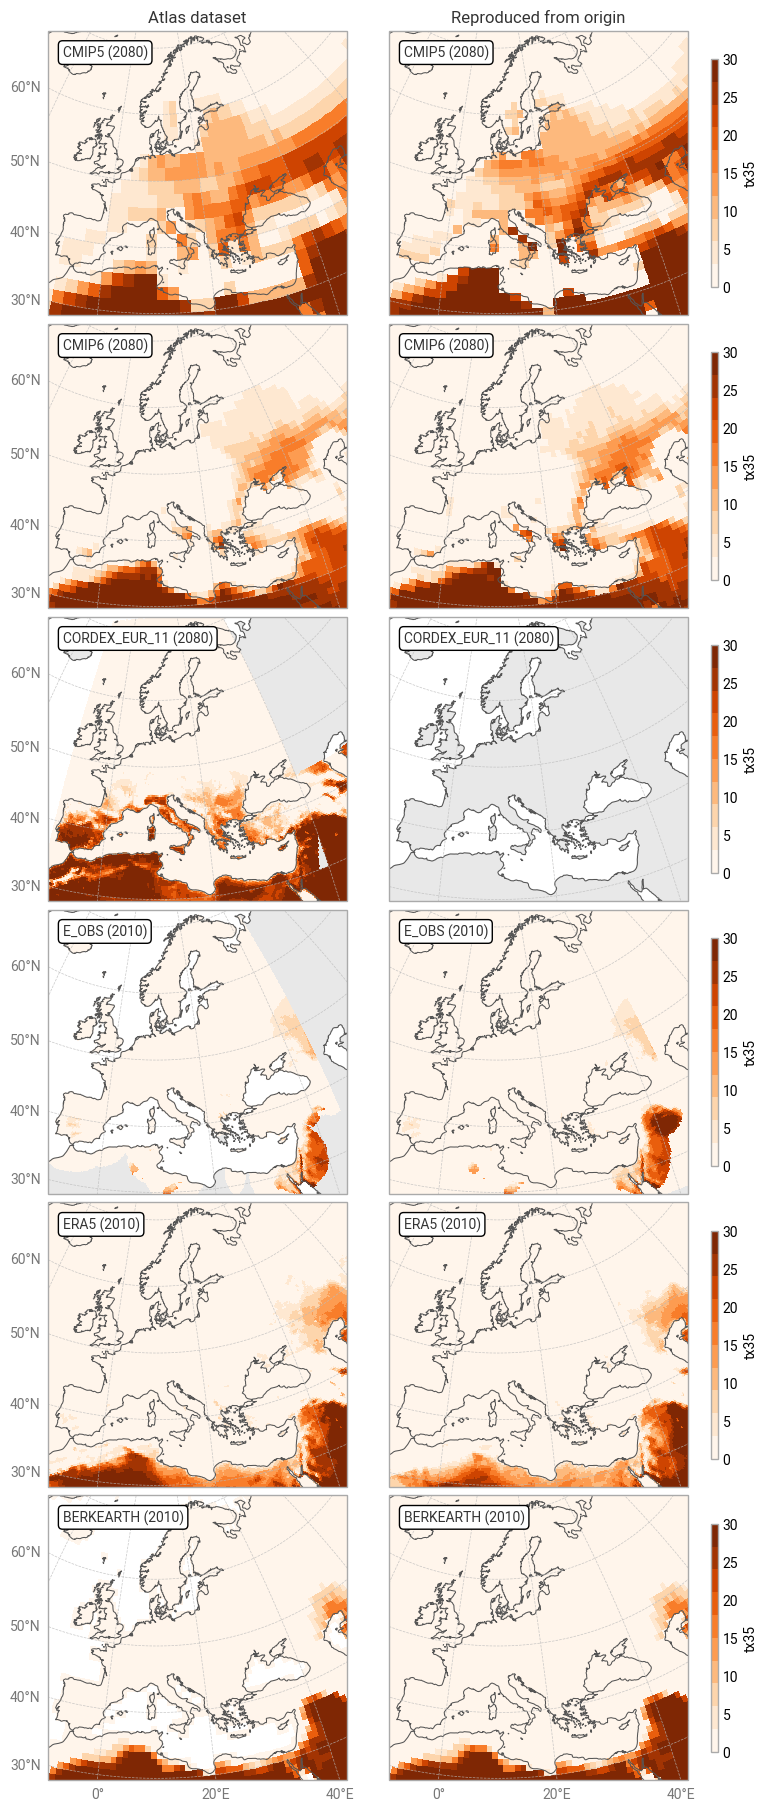

In [48]:
tx35_figs_by_key = geospatial_comparison_multiple_origin(ds_atlas_origins_tx35, indicator_tx35, 
                                                             "tx35", month, domain=domain)

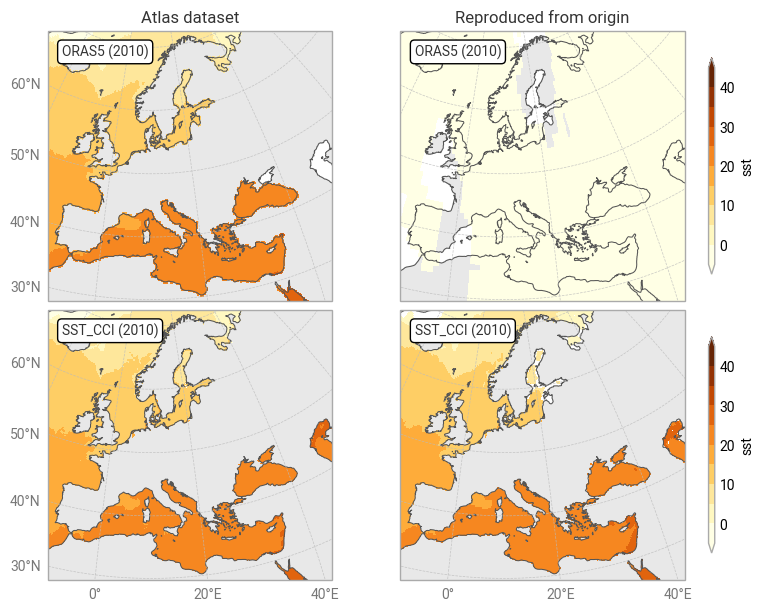

In [49]:
sst_figs_by_key = geospatial_comparison_multiple_origin(ds_atlas_origins_sst, indicator_sst, 
                                                             "sst", month, domain=domain)

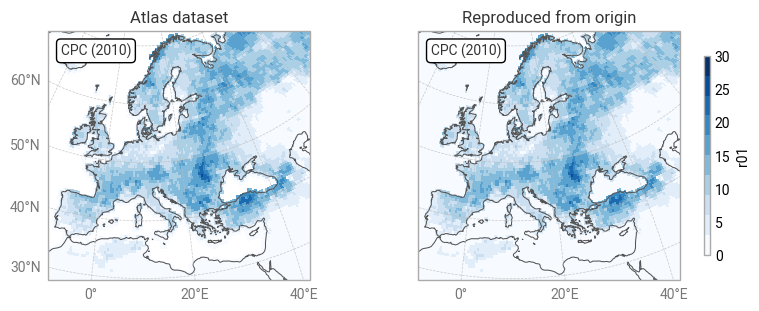

In [50]:
r01_figs_by_key = geospatial_comparison_multiple_origin(ds_atlas_origins_r01, indicator_r01, 
                                                             "r01", month, domain=domain)

For the overall comparison, we compare the distribution of indicator values across all pixels and months within each year.

In [ ]:
# Visualisation: Plot data in histograms
def histogram_comparison_by_origin(data1: dict, data2: dict, indicator: str, *,
                                      label1: str="Atlas dataset", label2: str="Reproduced from origin") -> plt.Figure:
    """
    Create a histogram for each dataset origin in two datasets.
    Flattens all data in the datasets, including spatial and temporal dimensions.
        TO DO: glue
    """
    # Setup origins
    common_keys = [k for k in data1 if k in data2]
    n_datasets = len(common_keys)
    loop_keys = tqdm(common_keys, desc="Plotting datasets", leave=False)
    
    # Create figure
    fig, axs = plt.subplots(nrows=n_datasets, ncols=2, sharex="row", sharey="row",
                            figsize=(5, 2*n_datasets), layout="constrained", squeeze=False)
    
    # Plot histograms of data
    # Loop over rows / origins
    for ax_row, key in zip(axs, loop_keys):
        data1_key = data1[key]
        data2_key = data2[key]

        for ax, data in zip(ax_row, (data1_key, data2_key)):
            # Flatten data
            d = data[indicator].values.ravel()

            # Create histogram
            ax.hist(d, bins=31, density=True, log=False, color="black")
    
            # Labels
            ax.grid(True, axis="both")
            ax.set_xlabel(indicator)
    
        ax_row[0].set_ylabel("Frequency")
        
        # Identify panel
        _add_textbox_to_subplots(indicator, *ax_row, right=True)
    
    # Titles on top
    titles = [label1, label2]
    for title, ax in zip(titles, axs[0]):
        ax.set_title(title)
        
    # Uncomment if running this notebook yourself:
    # Show result
    plt.show()
    
    # TO DO: glue
    return fig

In [ ]:
# tx35 histogram
tx35_fig_hist = histogram_comparison_by_origin(ds_atlas_origins_tx35, indicators_tx35, "tx35")

In [ ]:
# sst histogram
sst_fig_hist = histogram_comparison_by_origin(ds_atlas_origins_sst, indicators_sst, "sst")

In [ ]:
# r01 histogram
r01_fig_hist = histogram_comparison_by_origin(ds_atlas_origins_r01, indicators_r01, "r01")

#### Reproducibility: Comparison on Atlas grid

After regridding/interpolating, the indicator values reproduced from the origin dataset can be compared point-by-point to the values retrieved from the Atlas dataset. We first examine some metrics that describe the difference Δ between corresponding pixels:

In [ ]:
## Statistics
# Constants
NONZERO_THRESHOLD = 1e-5
NONZERO_THRESHOLD_PCT = 0.1

# Difference between datasets
def difference_between_datasets(data1: xr.Dataset, data2: xr.Dataset, diff_variables: Iterable[str]) -> xr.Dataset:
    """ Calculate the difference between two datasets, preserving CRS and metadata. """
    # Subtract
    data1, data2 = [d.drop_vars(["lat_bnds", "lon_bnds", "time_bnds", "height"], errors="ignore") for d in (data1, data2)]
    difference = xr.ufuncs.subtract(data1, data2)
    return difference

def relative_difference_between_datasets(data1: xr.Dataset, data2: xr.Dataset, reldiff_variables: Iterable[str]) -> xr.Dataset:
    """
    Calculate the relative [%] difference between two datasets, preserving CRS and updating metadata.
    Relative difference is calculated relative to the first dataset.
    Where data1 == 0 and data2 == 0, the relative difference is set to 0 too.
    """
    # Select and calculate
    data1, data2 = [dataset.drop_vars([var for var in dataset.data_vars if var not in [*reldiff_variables, "crs"]]) \
                        for dataset in (data1, data2)]

    relative_difference = (data1 - data2) / data1 * 100.

    # Replace 0/0 with 0
    data1_zero = (data1 <= NONZERO_THRESHOLD)  # Threshold slightly > 0 because of floating-point errors
    relative_difference = relative_difference.where(~data1_zero, 0.)

    # Add name
    relative_difference = relative_difference.assign_attrs({"name": "Atlas – Reproduced [%]"})

    return relative_difference

def fraction_over_threshold(data: pd.DataFrame, threshold: float=NONZERO_THRESHOLD) -> pd.DataFrame:
    """ Calculate the % of non-NaN cells in a dataframe greater than a given threshold. """
    data_over = (data >= threshold)
    frac_over = data_over.sum() / data_over.count() * 100.
    return frac_over

fraction_over_threshold_relative = partial(fraction_over_threshold, threshold=NONZERO_THRESHOLD_PCT)

In [ ]:
# do for one indicator at a time 
def comparison_statistics(dataset1: dict, dataset2: dict, indicator: str, *,
                          indicator_relative = True) -> pd.DataFrame:
    """
    Given two datasets, calculate a number of statistics for each variable and return the result in a table.
    This version is hardcoded for one indicator in multiple years.
    """
    common_keys = [k for k in dataset1 if k in dataset2]

    for key in common_keys:
        dataset1 = dataset1[key]
        dataset2 = dataset2[key]

        # If indicator_relative is not specified explicitly, assume it is the same as indicator
        if indicator_relative is True:
            indicator_relative = indicator
            differences_rel = relative_difference_between_datasets(dataset1, dataset2, reldiff_variables= [indicator_relative])
            differences_rel = differences_rel.to_dataframe()[[indicator_relative]]
            differences_rel_abs = differences_rel.abs()
            mapd =       differences_rel_abs.agg(["median"])  \
                                    .rename({"median": r"Median |Δ| [%]"})
            nonzeropct = differences_rel_abs.apply(fraction_over_threshold_relative)  \
                                    .rename(rf"% where |Δ| ≥ {NONZERO_THRESHOLD_PCT}%")
    
        
        # Calculate differences
        differences     =          difference_between_datasets(dataset1, dataset2, diff_variables=[indicator])
    
     
        # Convert to pandas
        differences = differences.to_dataframe()[[indicator]]
        differences_abs = differences.abs()
    
        # Calculate aggregate statistics
        md   =               differences.agg(["mean", "median"])  \
                                        .rename({"median": r"Median Δ", "mean": "Mean Δ"})
        mad  =           differences_abs.agg(["median"])  \
                                        .rename({"median": r"Median |Δ|"})
        nonzero =        differences_abs.apply(fraction_over_threshold)  \
                                        .rename(r"% where |Δ| ≥ ε")
    
        md, mad, mapd = [df.T for df in (md, mad, mapd)]
    
        # Calculate correlation coefficients
        corrs = {indicator: xr.corr(dataset1[indicator], dataset2[indicator]).values 
                 for indicator in [indicator]}
        corrs = pd.DataFrame.from_dict(corrs, orient="index", columns=["Pearson r"])
        
        # Combine statistics into one dataframe
        if indicator_relative is True:
            stats = pd.concat([md, mad, nonzero, mapd, nonzeropct, corrs], axis=1)
        else: 
            stats = pd.concat([md, mad, nonzero, corrs], axis=1)

    return stats

def display_difference_stats(dataset1: dict, dataset2: dict, *args, **kwargs) -> str:
    """ Given two datasets, calculate a number of statistics for each variable and display the result in a table. """
    comparison_stats = comparison_statistics(dataset1, dataset2, *args, **kwargs)
    formatted = comparison_stats.style \
                                .format(precision=5)  \
                                .set_caption("Atlas – Reproduced")
    return formatted

In [ ]:
# tx35 stats table
display_difference_stats(ds_atlas_origins_tx35, dataset_tx35, "tx35", indicator_relative = True)

In [ ]:
# sst stats table
display_difference_stats(ds_atlas_origins_tx35, dataset_tx35, "sst", indicator_relative = True)

In [ ]:
# r01 stats table
display_difference_stats(ds_atlas_origins_tx35, dataset_tx35, "tx35", indicator_relative = True)

This cell will be the conclusions:



In [ ]:
# Visualisation: Plot data + difference in histograms
def histogram_comparison_by_origin_with_difference(data1: dict, data2: dict, indicator: str, *,
                                                      label1: str="Atlas dataset", label2: str="Reproduced from origin") -> plt.Figure:
    """
    Create a histogram for each origin in two datasets, including the point-by-point difference.
    Flattens all data in the datasets, including spatial and temporal dimensions.
        TO DO: glue
    """
    # Setup origins
    common_keys = [k for k in data1 if k in data2]
    n_datasets = len(common_keys)

    loop_keys = tqdm(common_keys, desc="Plotting origin", leave=False)
    
    # Create figure
    fig, axs = plt.subplots(nrows=n_datasets, ncols=3,
                            figsize=(8, 2*n_datasets), layout="constrained", squeeze=False)

    # Setup x/y share -- cannot be done in plt.subplots because of difference panel not sharing these
    for ax_row in axs:
        _sharexy(ax_row[:-1])
    
    # Plot histograms of data
    # Loop over rows / indicators
    for ax_row, key in zip(axs, loop_keys):
        data1_key = data1[key]
        data2_key = data2[key]
        # Calculate difference
        difference = difference_between_datasets(data1_key, data2_key, indicator)
        
        # Loop over columns / data
        for ax, data in zip(ax_row, (data1_key, data2_key)):
            # Flatten data
            d = data[indicator].values.ravel()
    
            # Create histogram
            ax.hist(d, bins=31, density=True, log=False, color="black")

            # Labels
            ax.grid(True, axis="both")
            ax.set_xlabel(indicator)

            # Plot difference
            difference_here = difference[indicator].values.ravel()
            ax_row[-1].hist(difference_here, bins=31, density=True, log=True, color="black")
    
        ax_row[0].set_ylabel("Frequency")
        
        # Identify panel
        _add_textbox_to_subplots(indicator, *ax_row[:-1], right=True)
        _add_textbox_to_subplots(f"Δ {indicator}", ax_row[-1], right=True)

    for ax in axs[:, -1]:  # Symmetric xlims for difference
        _symmetric_xlim(ax)
    
    # Titles on top
    titles = [label1, label2, "Difference"]
    for title, ax in zip(titles, axs[0]):
        ax.set_title(title)
        
    # Uncomment if running this notebook yourself:
    # Show result
    plt.show()
    
    # TO DO: glue
    return fig

In [ ]:
# Histogram tx35
tx35_fig_hist = histogram_comparison_by_origin_with_difference(ds_atlas_origins_tx35, dataset_tx35, "tx35")

In [ ]:
# Histogram r01
sst_fig_hist = histogram_comparison_by_origin_with_difference(ds_atlas_origins_sst, indicators_sst, "sst")

In [ ]:
# Histogram sst
sst_fig_hist = histogram_comparison_by_origin_with_difference(ds_atlas_origins_sst, indicators_sst, "sst")

In [ ]:
#HERE

# Visualisation: Plot indicators geospatially
def geospatial_comparison_multiple_origin_with_difference(data1: dict, data2: dict, indicator: str, month: int, *,
                                                              label1: str="Atlas dataset", label2: str="Reproduced from origin",
                                                              domain: Optional[str | Domain]=None) -> ekp.Figure:
    """
    Plot a list of origins in two datasets.
    Assumes the data are from a single year.
    A specific month has to be specified.
        TO DO: glue
    """

    # Setup origins
    common_keys = [k for k in data1 if k in data2]
    n_datasets = len(common_keys)
    loop_keys = tqdm(common_keys, desc="Plotting origin", leave=False)

    # Create figure
    fig = ekp.Figure(rows=n_datasets, columns=3, size=(7.5, 2*n_datasets))
    
    for key in loop_keys:
        # Pre-process: Select data in one month, calculate difference
        data1 = data1[key]
        data2 = data2[key]
        data1_month, data2_month = select_month_in_multiple_datasets(data1, data2, month=month)
        difference = difference_between_datasets(data1_month, data2_month)
        
        # Plot indicators
  
        # Plot individual datasets
        subplots_data = _spatial_plot_append_subplots(fig, data1_month, data2_month, domain=domain, 
                                                      z=indicator, style=styles[indicator])

        # Plot difference
        subplot_diff = fig.add_map(domain=domain)
        subplot_diff.grid_cells(difference, z=indicator, style=styles[f"{indicator}_diff"])
    
        # Decorate: Text + Colour bar
        subplots_data[0].legend(label=indicator, location="left")
        subplot_diff.legend(label=f"Δ {indicator}", location="right")

    # Titles on top
    titles = [label1, label2, "Difference"]
    for title, subplot in zip(titles, fig.subplots):
        subplot.ax.set_title(title)

    # Decorate figure
    fig.land()
    fig.coastlines()
    fig.gridlines(linestyle=plt.rcParams["grid.linestyle"])
    
    # Uncomment if running this notebook yourself:
    # Show result
    plt.show()

    # TO DO: glue
    return fig

In [ ]:
tx35_diff_figs_by_key = geospatial_comparison_multiple_origin_with_difference(ds_atlas_origins_tx35, indicators_tx35, 
                                                             "tx35", month, domain = domian)

In [ ]:
sst_diff_figs_by_key = geospatial_comparison_multiple_origin_with_difference(ds_atlas_origins_sst, indicators_sst, 
                                                             "sst", month, domain = domain)

In [ ]:
r01_diff_figs_by_key = geospatial_comparison_multiple_origin_with_difference(ds_atlas_origins_r01, indicators_r01, 
                                                             "r01", 8, domain = domian)

## ℹ️ If you want to know more

### Key resources
The CDS catalogue entries for the data used were:
* Gridded dataset underpinning the Copernicus Interactive Climate Atlas: [multi-origin-c3s-atlas](https://doi.org/10.24381/cds.h35hb680)
  * [](./derived_multi-origin-c3s-atlas_consistency_q01)
  * [](./derived_multi-origin-c3s-atlas_consistency_q02)
  * [](./derived_multi-origin-c3s-atlas_consistency_q03)
* CMIP6 climate projections: [projections-cmip6](https://doi.org/10.24381/cds.c866074c)
  * [Quality assessments for CMIP6](../Climate_Projections/CMIP6/CMIP6.md)


Code libraries used:
* [earthkit](https://github.com/ecmwf/earthkit)
  * [earthkit-data](https://github.com/ecmwf/earthkit)
  * [earthkit-plots](https://github.com/ecmwf/earthkit-plots)
* [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas)
* [xclim](https://xclim.readthedocs.io/en/stable/) climate indicator tools


More about the Copernicus Interactive Climate Atlas and its IPCC predecessor:
* [Copernicus Interactive Climate Atlas application](https://atlas.climate.copernicus.eu/)
* [Gridded data underpinning the Copernicus Interactive Climate Atlas: Description of the datasets and variables](https://confluence.ecmwf.int/display/CKB/Gridded+data+underpinning+the+Copernicus+Interactive+Climate+Atlas%3A+Description+of+the+datasets+and+variables)
* [The Copernicus Interactive Climate Atlas: a tool to explore regional climate change](https://doi.org/10.21957/ah52ufc369)
* [Copernicus Interactive Climate Atlas: a new tool to visualise climate variability and change](https://www.ecmwf.int/en/newsletter/179/news/copernicus-interactive-climate-atlas-new-tool-visualise-climate-variability)
* [Implementation of FAIR principles in the IPCC: the WGI AR6 Atlas repository](https://doi.org/10.1038/s41597-022-01739-y)
* [Climate Change 2021 – The Physical Science Basis: Atlas](https://doi.org/10.1017/9781009157896.021)

### References
_To be replaced with numerical references once the text is finished_

[[Guti24](https://doi.org/10.21957/ah52ufc369)] J. M. Gutiérrez et al., ‘The Copernicus Interactive Climate Atlas: a tool to explore regional climate change’, ECMWF Newsletter, vol. 181, pp. 38–45, Oct. 2024, doi: 10.21957/ah52ufc369.

[[AtlasData](https://doi.org/10.24381/cds.h35hb680)] Copernicus Climate Change Service, ‘Gridded dataset underpinning the Copernicus Interactive Climate Atlas’. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), Jun. 17, 2024. doi: 10.24381/cds.h35hb680.

[[CMIP6data](https://doi.org/10.24381/cds.c866074c)] Copernicus Climate Change Service, ‘CMIP6 climate projections’. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), Mar. 23, 2021. doi: 10.24381/cds.c866074c.

[[Bur20](https://doi.org/10.1364/OE.391470)] O. Burggraaff, ‘Biases from incorrect reflectance convolution’, Optics Express, vol. 28, no. 9, pp. 13801–13816, Apr. 2020, doi: 10.1364/OE.391470.